In [1]:
import classiq
# !pip show classiq

In [2]:
from pyscf import gto, scf, mcscf, ao2mo, tools
from pyscf.mcscf import avas
from openfermion import jordan_wigner, save_operator, FermionOperator, QubitOperator
from classiq import synthesis, execution
from typing import List
from classiq.execution import (
    ClassiqBackendPreferences,
    ExecutionPreferences,
    set_quantum_program_execution_preferences,
)
import matplotlib.pyplot as plt

# Preprocessing

This part is already taken into account another DFT preprocessing where the geometry optimization is realized using Quantum Espresso. Below, we have the optimized coordinates of the atoms without the bottom layer (originally there were 27 Cu atoms, and here we are taking into account only the upper 18). With these coordinates, it is possible to define the molecule using PySCF and perform HF simulation.

In [3]:
coords = [
    # Middle layer Cu (z ≈17 A)
    ('Cu', [-0.0395020103, 1.4820503611, 17.1143137893]),
    ('Cu', [2.4994443187, 1.4824792111, 17.1149016882]),
    ('Cu', [5.0501143692, 1.4808569247, 17.1207591325]),
    ('Cu', [1.2307216878, 3.6822830061, 17.0781231482]),
    ('Cu', [3.7810206409, 3.7028835438, 17.0938506694]),
    ('Cu', [6.3307687416, 3.7046367936, 17.0970745783]),
    ('Cu', [2.5030214963, 5.8956616297, 17.0989339276]),
    ('Cu', [5.0714983075, 5.8828658294, 17.0761500349]),
    ('Cu', [7.6304264753, 5.9039376317, 17.1077863480]),

    # Top layer Cu (z ≈19 A)
    ('Cu', [-0.0859000009, 0.0037967297, 19.1531953408]),
    ('Cu', [2.5526884077, -0.0017635921, 19.1368324652]),
    ('Cu', [5.0666730153, 0.0078287410, 19.1573385137]),
    ('Cu', [1.2221691764, 2.2852913305, 19.1351989591]),
    ('Cu', [3.7949069965, 2.2438195621, 19.1469027886]),
    ('Cu', [6.3309339951, 2.2370558840, 19.1474912435]),
    ('Cu', [2.4714071248, 4.4276206962, 19.1376209578]),
    ('Cu', [5.0576842912, 4.3865808467, 19.1200076634]),
    ('Cu', [7.6311490771, 4.4237624444, 19.1426687590]),

    # Adsorbed O₂⁻
    ('O', [0.5749056752, -0.1223946577, 20.9180568583]),
    ('O', [1.9047215770, 0.1991137313, 20.9029578000])
]

Definition of the basis used in the DFT calculations.

In [4]:
#Here I'm defining the Gaussian basis. This is one of the pre processing steps where I'm unsure how to reproduce from the paper.
basis = {
    'Cu': gto.basis.parse('''
Cu    S
0.500000   1.0
0.250000   1.0
Cu    D
5.000000   1.0
2.500000   1.0
Cu    P
1.000000   1.0
'''),    
    'O': gto.basis.parse('''
O    S
2.941249   1.0
O    P
2.941249   1.0
''')
}

ecp = {
    'Cu': gto.basis.parse_ecp('''
Cu nelec 28
Cu ul
1      30.00000      10.000000
3      20.000000    200.000000
2      15.000000    -50.000000
''')
}

In [5]:
# !pip install pyscf

Definition of the molecule using the coordinates and basis defined before

In [6]:
# Defining the molecule
mol = gto.M(
    atom=coords,
    basis=basis,
    ecp=ecp,
    spin=0,
    charge=-0,
    verbose=4
)

System: uname_result(system='Linux', node='HOffice', release='5.15.167.4-microsoft-standard-WSL2', version='#1 SMP Tue Nov 5 00:21:55 UTC 2024', machine='x86_64')  Threads 20
Python 3.12.7 (main, Oct 10 2024, 01:52:20) [GCC 14.0.1 20240412 (experimental) [master r14-9935-g67e1433a94f]]
numpy 1.26.4  scipy 1.15.3  h5py 3.13.0
Date: Mon May 26 19:13:53 2025
PySCF version 2.9.0
PySCF path  /home/hanan/CorrosionModel/.venv/lib/python3.12/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 20
[INPUT] num. electrons = 34
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 Cu    -0.039502010300   1.482050361100  17.114313789300 AA   -0.074647980837   2.800669285292  32.341365871644 Bohr   0.0
[INPUT]  2 Cu     2.499444318700   1.482479211100

HF Calculation

In [7]:
# There are several ways of doing these HF calculations. I asked chatGPT to indicate me the best ways, and it seems like ROHF and UKS are the most prominent for this case.
rhf = scf.ROHF(mol)
rhf.kernel() 
#mf = scf.UKS(mol)
#mf.xc = 'SCAN'  
#mf.mo_coeff = rhf.mo_coeff
#mf.conv_tol = 1e-8  
#mf.diis_space = 10 
#mf.level_shift = 0.5 
#mf.max_cycle = 500  
#mf.kernel()



******** <class 'pyscf.scf.rohf.ROHF'> ********
method = ROHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpq9xx1avh
max_memory 4000 MB (current use 380 MB)
num. doubly occ = 17  num. singly occ = 0
Set gradient conv threshold to 3.16228e-05
init E= -59.8736785685392
  HOMO = -0.912500345854948  LUMO = -0.908831752126335
cycle= 1 E= -75.508880677009  delta_E= -15.6  |g|= 1.67  |ddm|= 3.83
  HOMO = 0.693817227408341  LUMO = 0.809807660908892
cycle= 2 E= -51.6391679192103  delta_E= 23.9  |g|= 2.33  |ddm|= 6.07
  HOMO = 0.155643224835473  LUMO = 0.170800160680778
cycle= 3 E= -77.4008559625795  delta_E= -25.8  |g|= 1.46  |ddm|= 5.68
  HOMO = 0.165630928842859  LUMO = 0.1956244098781
cycle= 4 E= -64.4035515705066  delta_E=   13  |g|= 1.67  |dd

-88.89236000975976

AVAS calculation

In [8]:
# Originally in the paper they use threshold = 0.1. For some reason they end up with 2/2, 4/6 or 6/10 active spaces, and I don't. Here I'm only showcasing the threshold = 0.55 so I can speedup some calculations.
# If you set threshold = 0.1, it will take quite some time to synthesize and run the circuit, because you will have a really big ansatz with more than 200 parameters.
n_orb, n_elec, mo_coeff = avas.avas(
    rhf,
    aolabels=['O 2p', 'Cu 3d'],
    threshold=0.55,
    openshell_option=2,
    canonicalize=True
)


******** AVAS flags ********
aolabels = ['O 2p', 'Cu 3d']
ncore = 0
minao = minao
threshold = 0.55
with_iao = False
openshell_option = 2
canonicalize = True

** AVAS **
  Total number of HF MOs  is equal to    170
  Number of occupied HF MOs is equal to  17
reference AO indices for minao ['O 2p', 'Cu 3d']:
 [272 273 274 277 278 279]
Option 2: threshold 0.55
Active from occupied = 2 , eig [0.58103829 0.58845057]
Inactive from occupied = 15
Active from unoccupied = 1 , eig [0.56330144]
Inactive from unoccupied = 152
Dimensions of active 3
# of alpha electrons 2
# of beta electrons 2


In [9]:
mc = mcscf.CASSCF(rhf, n_orb, n_elec)
mc.mo_coeff = mo_coeff  # Critical: Use AVAS-sorted orbitals
mc.fcisolver.conv_tol = 1e-6
mc.kernel()


******** <class 'pyscf.mcscf.mc1step.CASSCF'> ********
CAS (2e+2e, 3o), ncore = 15, nvir = 152
max_cycle_macro = 50
max_cycle_micro = 4
conv_tol = 1e-07
conv_tol_grad = None
orbital rotation max_stepsize = 0.02
orbital rotation threshold for CI restart = 0.01
augmented hessian ah_max_cycle = 30
augmented hessian ah_conv_tol = 1e-12
augmented hessian ah_linear dependence = 1e-14
augmented hessian ah_level shift = 1e-08
augmented hessian ah_start_tol = 2.5
augmented hessian ah_start_cycle = 3
augmented hessian ah_grad_trust_region = 3
kf_trust_region = 3
kf_interval = 4
ci_response_space = 4
ci_grad_trust_region = 3
with_dep4 0
natorb = False
canonicalization = True
sorting_mo_energy = False
ao2mo_level = 2
chkfile = /tmp/tmpq9xx1avh
max_memory 4000 MB (current use 1398 MB)
internal_rotation = False
******** <class 'pyscf.fci.direct_spin1.FCISolver'> ********
max. cycles = 50
conv_tol = 1e-06
davidson only = False
linear dependence = 1e-12
level shift = 0.001
max iter space = 12
max_mem

(-88.9878855379883,
 -8.94588117830395,
 FCIvector([[-0.78011722,  0.01404108,  0.04173109],
            [ 0.01404108,  0.61338622,  0.02321955],
            [ 0.04173109,  0.02321956,  0.1010886 ]]),
 array([[ 1.25440548e-05,  1.19155488e-06, -9.59680451e-02, ...,
         -1.08389170e-06, -1.87701512e-05, -4.86641090e-06],
        [-3.27833198e-08,  3.86992131e-08, -3.49356513e-04, ...,
          7.16930018e-06, -7.64692841e-06, -4.61293100e-06],
        [-1.74782280e-06, -9.96611925e-08,  1.68161563e-03, ...,
          1.61442441e-06, -2.19862549e-06, -4.89743985e-06],
        ...,
        [-7.42012945e-04,  8.37428647e-03, -6.02375950e-03, ...,
         -1.41747171e-06,  2.14223227e-07, -1.03298693e-06],
        [-1.88803769e-04,  2.29079466e-03,  1.21546572e-03, ...,
          5.18932300e-07, -3.67470181e-07,  1.32841102e-07],
        [ 1.47856619e-04, -3.83145939e-03,  1.79575533e-02, ...,
         -1.11867725e-06, -6.13016974e-07,  1.20444568e-06]]),
 array([-9.7747449 , -9.7447

Evaluation of the coefficients of the second quantization form.

In [10]:
# These are the coefficients of the a,a.dag terms in second quantization form
h1e, energy_core = mc.get_h1eff()
h2_compressed = mc.get_h2eff() 
h2 = ao2mo.restore(1, h2_compressed, n_orb)
# This is just a sanity check:
h2.shape

(3, 3, 3, 3)

# OpenFermion and PySCF

Here, we can use the results obtained together with OpenFermion to build the Hamiltonian of the problem using jordan-wigner over the second quantization hamiltonian.

In [11]:
ham_fermionic = FermionOperator()

# Add core energy (constant term)
ham_fermionic += FermionOperator.identity() * energy_core

# One-body terms (include both α and β spins)
for p in range(mc.ncas):
    for q in range(mc.ncas):
        coeff = h1e[p, q]
        # α-spin terms (indices 2p, 2q)
        ham_fermionic += FermionOperator(f"{2*p}^ {2*q}", coeff)
        # β-spin terms (indices 2p+1, 2q+1)
        ham_fermionic += FermionOperator(f"{2*p+1}^ {2*q+1}", coeff)

for p in range(mc.ncas):
    for q in range(mc.ncas):
        for r in range(mc.ncas):
            for s in range(mc.ncas):
                coeff = 0.5 * h2[p, q, r, s]
                for sigma in [0, 1]:    # 0 = alpha, 1 = beta
                    for tau in [0, 1]:
                        ham_fermionic += FermionOperator(
                            f"{2*p + sigma}^ {2*q + tau}^ "
                            f"{2*r + tau} {2*s + sigma}", 
                            coeff
                        )

# Jordan-Wigner transformation
qubit_hamiltonian = jordan_wigner(ham_fermionic)
qubit_hamiltonian.compress(abs_tol=1e-12)

print(f"Qubit Hamiltonian has {len(qubit_hamiltonian.terms)} terms")
print("Hamiltonian terms:")
print(*list(qubit_hamiltonian.terms.items()), sep="\n")

Qubit Hamiltonian has 136 terms
Hamiltonian terms:
((), -91.70616410317639)
(((0, 'Z'),), 1.7335034395983797)
(((1, 'Z'),), 1.7335034395983797)
(((0, 'Y'), (1, 'Z'), (2, 'Y')), -0.000624210373972072)
(((0, 'X'), (1, 'Z'), (2, 'X')), -0.000624210373972072)
(((1, 'Y'), (2, 'Z'), (3, 'Y')), -0.000624210373972072)
(((1, 'X'), (2, 'Z'), (3, 'X')), -0.000624210373972072)
(((0, 'Y'), (1, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'Y')), 0.00029653919029364896)
(((0, 'X'), (1, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'X')), 0.00029653919029364896)
(((1, 'Y'), (2, 'Z'), (3, 'Z'), (4, 'Z'), (5, 'Y')), 0.00029653919029364896)
(((1, 'X'), (2, 'Z'), (3, 'Z'), (4, 'Z'), (5, 'X')), 0.00029653919029364896)
(((2, 'Z'),), 1.721990940309432)
(((3, 'Z'),), 1.721990940309432)
(((2, 'Y'), (3, 'Z'), (4, 'Y')), -0.00018056589354261703)
(((2, 'X'), (3, 'Z'), (4, 'X')), -0.00018056589354261703)
(((3, 'Y'), (4, 'Z'), (5, 'Y')), -0.00018056589354261703)
(((3, 'X'), (4, 'Z'), (5, 'X')), -0.00018056589354261703)
(((4, 'Z'),), 1.7131629672

### Performing Jordan-Wigner transformation to obtain the qubit Hamiltonian:

In [12]:
from classiq import PauliTerm, Pauli
pauli_char_to_obj = {"I": Pauli.I, "Z": Pauli.Z, "X": Pauli.X, "Y": Pauli.Y}


def qubit_op_to_hamiltonian(qbit_op, n_qubits):
    """Convert OpenFermion QubitOperator to list of PauliTerm"""
    hamiltonian = []

    for term, coeff in qbit_op.terms.items():

        pauli_list = [Pauli.I] * n_qubits  # Default to identity

        for qubit, pauli in term:
            pauli_list[qubit] = pauli_char_to_obj[pauli]  # Replace with correct Pauli

        # Append list-style Pauli term
        hamiltonian.append(PauliTerm(pauli=pauli_list[::-1], coefficient=coeff))

    return hamiltonian

# This is the hamiltonian of the system after performing jordan-wigner:
measured_hamiltonian = qubit_op_to_hamiltonian(qubit_hamiltonian, 2*n_orb)

### Evaluating the Hartree-Fock state

In [13]:
# If changing threshold, these lists needs to be changed according to the alpha and beta electrons occupation
alpha_occ = [1.0, 1.0, 0.0]  # 2 alpha-electrons in first 2 orbitals
beta_occ = [1.0, 0.0, 0.0]   # 1 beta-electrons in first orbital


alpha_occupied = [i for i, occ in enumerate(alpha_occ) if occ > 0.5]
beta_occupied = [i + n_orb for i, occ in enumerate(beta_occ) if occ > 0.5]
occupied_spin_orbitals = alpha_occupied + beta_occupied 

# Step 2: Build the HF state bitstring
n_qubits = 2 * n_orb
hf_bitstring = ['0'] * n_qubits
for idx in occupied_spin_orbitals:
    hf_bitstring[idx] = '1'
hf_bitstring = ''.join(hf_bitstring[::-1])  # OpenFermion uses little-endian

print(f"HF state: |{hf_bitstring}>")

HF state: |001011>


### Evaluating the generator for the UCCSD ansatz, $\textit{i.e.}$, the operators that generate a single or double excitation of the electrons.

In [14]:
# If changing threshold, these parameters also need to be changed
n_elec_alpha = 2
n_elec_beta = 1 
 
occupied = alpha_occupied + beta_occupied

# Virtual spin orbitals (unoccupied in HF)
virtual = [i for i in range(2*n_orb) if i not in occupied]


def generate_uccsd_excitations(occupied, virtual):
    singles = []
    doubles = []
    
    # Single excitations (i -> a)
    for i in occupied:
        for a in virtual:
            singles.append((i, a))
    
    # Double excitations (i,j -> a,b)
    for i in occupied:
        for j in occupied:
            if j <= i:
                continue  # Avoid duplicates
            for a in virtual:
                for b in virtual:
                    if b <= a:
                        continue  # Avoid duplicates
                    doubles.append((i, j, a, b))
    
    return singles, doubles

singles, doubles = generate_uccsd_excitations(occupied, virtual)

### Associating each group of generators with its own parameter in the VQE execution

In [15]:
def build_uccsd_ansatz(singles, doubles):

    qubit_generator_singles = []
    qubit_generator_doubles = []
    # Add parameterized UCCSD excitations
    for idx, (i, a) in enumerate(singles):
        generator = FermionOperator(f"{a}^ {i}") - FermionOperator(f"{i}^ {a}")
        qubit_generator_singles.append(jordan_wigner(generator))
    
    for idx, (i, j, a, b) in enumerate(doubles):
        generator = FermionOperator(f"{a}^ {b}^ {j} {i}") - FermionOperator(f"{i}^ {j}^ {b} {a}")
        qubit_generator_doubles.append(jordan_wigner(generator))
    
    return qubit_generator_singles, qubit_generator_doubles
generator_list_singles, generator_list_doubles = build_uccsd_ansatz(singles,doubles)

def generate_pauli_terms_list(qubit_generators_singles: List[QubitOperator], qubit_generators_doubles: List[QubitOperator]) -> List[PauliTerm]:

    pauli_terms_groups = []
        
    # Process single excitation generators
    for generator in qubit_generators_singles:
        group = []
        for term, coeff in generator.terms.items():
            pauli_list = [Pauli.I] * n_qubits
            for (qubit_idx, pauli_char) in term:
                if pauli_char == 'X':
                    pauli_list[qubit_idx] = Pauli.X
                elif pauli_char == 'Y':
                    pauli_list[qubit_idx] = Pauli.Y
                elif pauli_char == 'Z':
                    pauli_list[qubit_idx] = Pauli.Z
            group.append(PauliTerm(pauli_list, coeff.imag))
        pauli_terms_groups.append(group)
    
    # Process double excitation generators
    for generator in qubit_generators_doubles:
        group = []
        for term, coeff in generator.terms.items():
            pauli_list = [Pauli.I] * n_qubits
            for (qubit_idx, pauli_char) in term:
                if pauli_char == 'X':
                    pauli_list[qubit_idx] = Pauli.X
                elif pauli_char == 'Y':
                    pauli_list[qubit_idx] = Pauli.Y
                elif pauli_char == 'Z':
                    pauli_list[qubit_idx] = Pauli.Z
            group.append(PauliTerm(pauli_list, coeff.imag))
        pauli_terms_groups.append(group)
    
    return pauli_terms_groups

In [16]:
generators = generate_pauli_terms_list(generator_list_singles,generator_list_doubles)
n_params = len(generators)

### These are parameters for the quantum program, such as number of iterations, initial parameters and convergence tolerance.

In [17]:
from classiq import QConstant, CArray, CInt, CReal
hamiltonian_qmod = QConstant("hamiltonian_qmod", CArray[PauliTerm], measured_hamiltonian)
max_iter_qmod = QConstant("max_iter_qmod", CInt, 500)
initial_params_qmod = QConstant("initial_params_qmod", CArray[CInt], [0] * n_params)
tol_qmod = QConstant("tol_qmod", CReal, 0.001)

### Quantum programs with Classiq: The main function.

In [18]:
from classiq import qfunc, Output, QArray, QBit, allocate, X, suzuki_trotter

@qfunc(generative=True)
def main(params: CArray[CReal, n_params], qbv:Output[QArray[QBit]]):
    allocate(n_qubits,qbv)
    # Hartree-Fock initial state preparation, executed using the HF bitstring.
    i = 0
    for idx in hf_bitstring:
        if idx=='1':
            X(qbv[i])
        i+=1
    i=0
    # Execution of the Trotter-Suzuki for each parameter, since the generators were divided into groups of the same parameter, you can execute an instance of the Trotter-Suzuki expansion for every parameter.
    for ham in generators:
        suzuki_trotter(
            ham,
            evolution_coefficient=-params[i],
            order=1,
            repetitions=1,
            qbv=qbv,
        )
        i+=1

/tmp/ipykernel_23133/3717950702.py:3: ClassiqDeprecationWarning: The use of `generative=True` is no longer required. Note that the treatment of parameters of Qmod types will change from Python value to symbolic in a near release. Change Qmod types to the corresponding Python built-in types in order to use the parameters in Python expression contexts.
Recommended changes:
@qfunc(generative=True) -> @qfunc
CInt->int
CReal->float
CArray->list

For more information see https://docs.classiq.io/latest/qmod-reference/language-reference/generative-descriptions/
  @qfunc(generative=True)


### Classical iteration of the quantum program: cmain function

In [19]:
from classiq import cfunc, Optimizer, vqe, save

# Here we are defining some characteristics of the classical optimization routine, such as the initial parameter that are associated to each excitation group of generators, optimization method (e.g. COBYLA or ADAM), number of iterations, and tolerance.
@cfunc
def cmain() -> None:
    res = vqe(
        hamiltonian_qmod,
        False,
        initial_params_qmod,
        optimizer=Optimizer.COBYLA,
        max_iteration=max_iter_qmod,
        tolerance=tol_qmod,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1.0,
    )
    save({"result": res})

In [20]:
from classiq import create_model, synthesize, Preferences

qmod = create_model(main, classical_execution_function=cmain, preferences=Preferences(timeout_seconds= 1000))
qprog = synthesize(qmod)

### Execution of the quantum program in the statevector simulator, by changing the `backend_name` one can execute it on different simulators or the available real hardware.

In [22]:
from classiq.execution import execute

#num_shots =1 because we are running on a statevector simulator, if using real hardware it is necessary to set more shots.
qprog = set_quantum_program_execution_preferences(
    qprog,
    preferences=ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name="simulator_statevector"
        ),
    ),
)
res = execute(qprog).result()

ImportError: cannot import name 'execute' from 'classiq.execution' (/home/hanan/CorrosionModel/.venv/lib/python3.12/site-packages/classiq/execution/__init__.py)

### Post processing: Classiq structures the output of the VQE execution in a dictionary, where you can plot the values of the different iterations and analyze the results.

optimizer result classiq: -91.42239304072238


Text(0.5, 1.0, 'VQE result for Cu O2-')

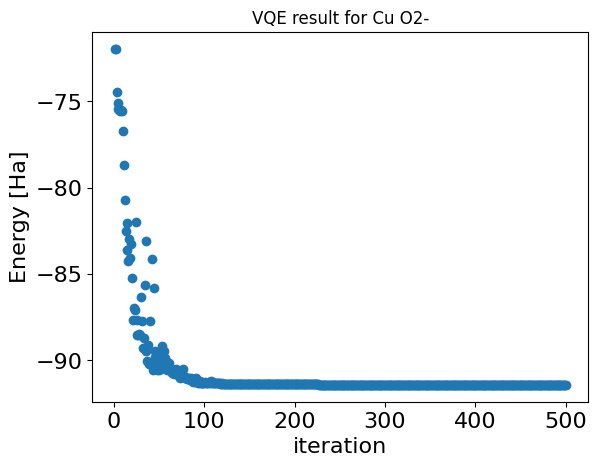

In [ ]:
optimizer_res = res[0].value.energy
print(f"optimizer result classiq: {optimizer_res}")

vqe_results = {
    intermediate_result.iteration_number: intermediate_result.mean_all_solutions
    for intermediate_result in res[0].value.intermediate_results
}


plt.plot(vqe_results.keys(), vqe_results.values(), "o")
plt.ylabel("Energy [Ha]", fontsize=16)
plt.xlabel("iteration", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title("VQE result for Cu O2-")